# Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [7]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [8]:
def sampleNeff(data: np.ndarray, k1percent: float = 0.0, ipercent: float = 0.4) -> int:
    N = len(data)
    k1 = int(k1percent * N)
    k2 = N-1

    icutoff = int(k2 * ipercent)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) for i in range(1, Neq)]) / (var * (Neq - 1))
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8128417122282972
Neff: 47.96411440277367
Energy = -0.18590284296301504
Variance on Energy = 0.022359132513266176

Beta = 0.300
Acceptance: 0.7314308574476597
Neff: 73.83514727303594
Energy = -0.23935720722725243
Variance on Energy = 0.022267612831891655

Beta = 0.400
Acceptance: 0.6462861714895319
Neff: 87.35292057069638
Energy = -0.32243878665544695
Variance on Energy = 0.021932035844023215

Beta = 0.500
Acceptance: 0.5739431924256567
Neff: 108.9594359980833
Energy = -0.3741628275097654
Variance on Energy = 0.01979184798305001

Beta = 0.600
Acceptance: 0.5094012535004667
Neff: 123.1160722130684
Energy = -0.41379055172458096
Variance on Energy = 0.018873036915932385

Beta = 0.700
Acceptance: 0.45146019469262566
Neff: 120.36362074126602
Energy = -0.4587615261715566
Variance on Energy = 0.01833750825169769

Beta = 0.800
Acceptance: 0.40212028270436057
Neff: 136.1654121161614
Energy = -0.47323849690043107
Variance on Energy = 0.011618231406161457

Beta = 0.900
A

Text(0.5, 1.0, 'Parameter Sweep')

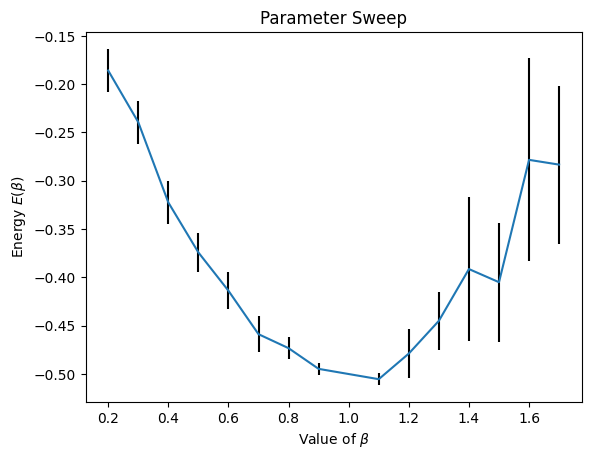

In [9]:
# Parameters
sampleM = 15000
discard = 1500

# Sweep Variational Parameter
betaMin = 0.2
betaMax = 1.7

Ebeta = []
Estd = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs = samplePos(sampleM, betaStart, delta=4)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    El = -0.5*betaStart*(betaStart - 2/Rs) - 1.0 / Rs

    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4500750125020837
Neff: 111.21050868603155
[np.float64(1.4), np.float64(1.6), np.float64(1.8), np.float64(2.0), np.float64(2.2), np.float64(2.4000000000000004), np.float64(2.6), np.float64(2.8), np.float64(3.0)]

BetaMid = 1.400
Acceptance: 0.5812635439239874
Neff: 55.90561560567252
[np.float64(1.0999999999999999), np.float64(1.2), np.float64(1.2999999999999998), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.7), np.float64(1.7999999999999998), np.float64(1.9)]

BetaMid = 1.100
Acceptance: 0.6586931155192532
Neff: 88.09881099256893
[np.float64(0.8499999999999999), np.float64(0.8999999999999999), np.float64(0.9499999999999998), np.float64(0.9999999999999999), np.float64(1.0499999999999998), np.float64(1.0999999999999999), np.float64(1.15), np.float64(1.2), np.float64(1.25), np.float64(1.2999999999999998), np.float64(1.3499999999999999)]

BetaMid = 1.000
Acceptance: 0.6896149358226371
Neff: 63.414634029843526
[np.float64(0.8749999999999999), 

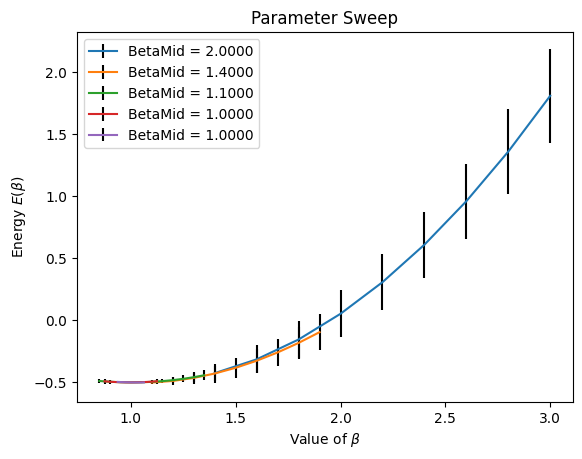

In [21]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 11
betaMult = 0.5

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()